# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

## **Importing the necessary libraries and overview of the dataset**

In [22]:
# Library to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Numeric and DataFrame computations
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary output to prevent from raising key error
from collections import defaultdict

# Performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [24]:
df = pd.read_csv('ratings_Electronics.csv')

#Add column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

#Drop the column timestamp
df = df.drop('timestamp', axis = 1)

#copy the data to another DataFrame called df
dfCopy = df.copy(deep = True)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [25]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [26]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [27]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [28]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [29]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [30]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

#### **Observation:**
There are 65290 columns and 3 rows present in the data.

### **Data types**

In [31]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


#### **Observation:**
- We have three columns, where `user_id` and `prod_id` variables have the data type object.
- The `rating` variable has numeric datatype.

### **Checking for missing values**

In [32]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Observation:** There are no missing values in the columns.

### **Summary Statistics**

In [33]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


#### **Observation:**
- The average rating given is around 4.3, with a standard deviation of 0.98.
- The minimum rating is 1 and maximum is 5 as expected.
- 50% - 75% of user's ratings are 5, showing that most of the users tend to give good ratings.

### **Checking the rating distribution**

<Axes: xlabel='rating'>

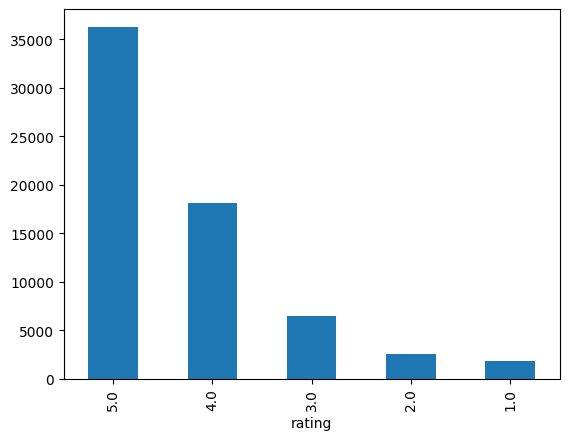

In [34]:
# Create the bar plot and provide observations
df_final.rating.value_counts().plot(kind = 'bar')

#### **Obesrvations:**
- Rating 5.0 has highest count of ratings of around 35000 and accounts for majority of the ratings, Showing users give high rating.
- Rating 4.0 follows the count between 15000 and 20000.

### **Checking the number of unique users and items in the dataset**

In [35]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in the dataset: ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the dataset: ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in the dataset:  1540
Number of unique PRODUCTS in the dataset:  5689


#### **Observations:**
- The final data consists of 65,290 observations, which suggests a substantial amount of data available for analysis.
- The dataset contains 1,540 unique users, indicating a broad range of individuals or entities represented in the data.
- With 5,689 unique products, we can say that a wide range of products or services being captured in the data.

### **Users with the most number of ratings**

In [36]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id')['rating'].count().sort_values(ascending = False).head(10)

,rating
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


#### **Observation:**
- User `ADLVFFE4VBT8` has the highest number with 295 ratings, followed by user `A3OXHLG6DIBRW8` with 230 ratings.
- User `A3LGT6UZL99IW1` is in the last but not least with 179 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [37]:
# Calculate the average rating for each product
avgRating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
ratingCount = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
finalRating = pd.DataFrame({'avg_rating': avgRating, 'rating_count': ratingCount})

# Sort the dataframe by average of ratings in the descending order
finalRating.sort_values('avg_rating', ascending = False).head()

# See the first five records of the "final_rating" dataset
finalRating.head()


,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [38]:
finalRating['rating_count'].value_counts()

,count
rating_count,
5,1082
6,796
7,637
8,495
9,416
...,...
90,1
167,1
71,1


In [39]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(finalRating, n, min_interaction):

    # Finding products with minimum number of interactions
      recommendations = finalRating[finalRating['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
      recommendations = recommendations.sort_values('avg_rating', ascending = False)

    # Return the top n products
      return recommendations.index[:n]



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [40]:
#Recommend top 5 products with a minimum of 50 interactions based on popularity
rec = top_n_products(finalRating, 5, 50)

#Name of thr products
listOfProducts = []
for i in rec:
  listOfProducts.append(df_final[df_final['prod_id'] == str(i)]['prod_id'].unique()[0])

print(listOfProducts)

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [41]:
# Recommend top 5 products with a minimum 100 interactions
rec2 = top_n_products(finalRating, 5, 100)

#Name of the products
listOfProducts2 = []
for i in rec2:
  listOfProducts2.append(df_final[df_final['prod_id'] == str(i)]['prod_id'].unique()[0])

print(listOfProducts2)


['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [42]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [43]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

In [44]:
#Encoding user_id and prod_id for simplicity
from sklearn.preprocessing import LabelEncoder
data=df_final[['user_id','prod_id']].apply(LabelEncoder().fit_transform)
data['rating']=df_final['rating']
data.head()

,user_id,prod_id,rating
1309,1050,0,5.0
1321,125,0,1.0
1334,785,0,3.0
1450,1495,0,5.0
1455,164,0,1.0


Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [45]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size= 0.2, random_state= 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [46]:
# Declaring the similarity options
simOption = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options= simOption, verbose= False)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


#### **Observation:**
- From the above output, we get that the baseline model has `RMSE = 1.0012` on the test set.
- We are getting a `Presion` of around 0.85, meaning 85% of the recommended products are relevent.
- With a `Recall` of around 0.86, we get that 86% of relevent products are recommended.
- `F_1 score` of the baseline model is around 0.85, indicating that most of the relevent products are recommended and recommended products are relevent.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [47]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui= 5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

#### **Observation:**
We Observe that the actual rating for the sample user is 5 and the predicted rating is 3.4.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [48]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != '1400501466'].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [49]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", '1400501466', verbose= True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### **Observation:**
We Observe that the predicted rating is 4.29 by this similarity based baseline model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [50]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
                }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9720040485090137
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [51]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
simAlgoTune = KNNBasic(sim_options= sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
simAlgoTune.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(simAlgoTune)


RMSE: 0.9532
Precision:  0.847
Recall:  0.893
F_1 score:  0.869


#### **Observation:**
- We Observe that after tuning the model, `RMSE` has reduced from 1.0012 to 0.95.
- `F_1 score` has also slightly improved after tuning.
- the above data shows that the model performance has improved slightly after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [52]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
simAlgoTune.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [53]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
simAlgoTune.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### **Observation**
- The tuned model's predicted rating given by `user_id: A3LDPF5FMB782Z` has increased from 3.4 to 4.29.
- On the other hand,the predicted rating given by `used_id: A34BZM6S9L7QI4` remians the same for the tuned model.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [54]:
# 0 is the inner id of the above user
simAlgoTune.get_neighbors(0, 5)

[6, 42, 44, 54, 66]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [55]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [56]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, simAlgoTune)

In [57]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B004RORMF6,5.0
1,B000067RT6,5.0
2,B000BQ7GW8,5.0
3,B001TH7GUU,5.0
4,B005ES0YYA,5.0


#### **Observation:**
All five products have received the highest possible predicted rating of 5.0, suggesting that these products are expected to be highly popular or well-received by users according to the recommendation system's predictions.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [58]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose= False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


#### **Observation:**
From the above data, we see that the `RMSE` value is approximately equal to 1 and the `F_1 score = 0.84` on the test set.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [59]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

#### **Obesrvation:**
The predicted rating for the `prod_id: A3LDPF5FMB782Z` is 4.27.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [60]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', r_ui = 5, verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### **Obesrvation:**
The predicted rating for the `prod_id: A34BZM6S9L7QI4` is approximately 4.3.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [62]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9], 'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv = 3)

# Fitting the data
grid_obj.fit(data)

# Find the best RMSE score
print(grid_obj.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [63]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
simAlgoOptimzed = KNNBasic(sim_options= sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
simAlgoOptimzed.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(simAlgoOptimzed)


RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


#### **Observation:**
- The optimized item-item collaborative filtering model achieved an `RMSE` of 0.9578, indicating reasonable accuracy in predicting ratings.
- The model showed strong recommendation capabilities with high `precision` (0.839), `recall` (0.88), and `F1-score` (0.859).

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [64]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
simAlgoOptimzed.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [65]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
simAlgoOptimzed.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### **Observation:**
- The tuned model prediction for the rating has increased to 4.71 from 4.27 for user A3LDPF5FMB782Z and item 1400501466, which is relatively close to the actual rating of 5.00.
-For user A34BZM6S9L7QI4 and the same item, the model estimated an approximate rating of 4.3, which is still the same even after tuning.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [66]:
simAlgoOptimzed.get_neighbors(0, 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [67]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, simAlgoOptimzed)


In [68]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [69]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8887
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


#### **Observation:**
- We get an `RMSE` of 0.8887, demonstrating strong predictive accuracy compared to the item-item collaborative filtering approach.
- We also get recommendation quality with high `precision` (0.853), `recall` (0.88), and `F1-score` (0.866).

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [70]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:** The SVD model predicted a rating of 4.08 given by user A3LDPF5FMB782Z for item 1400501466.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [71]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here:** The SVD Model prediction for the rating of the same product given by user A34BZM6S9L7QI4 is 4.4.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [72]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.1],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gS = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs=-1)

# Fitting the data
gS.fit(data)

# Best RMSE score
print(gS.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gS.best_params['rmse'])

0.896321672072689
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [74]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs = 30, lr_all = 0.005, reg_all = 0.4, random_state = 1)

# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.8827
Precision:  0.853
Recall:  0.888
F_1 score:  0.87


**Write your observations here:** After tuning, the `RMSE` decreased from 0.8887 to 0.8827, indicating marginally better predictive accuracy, whereas, the `F_1 score` increased from 0.86 to 0.87

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [75]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0413207714150925, details={'was_impossible': False})

In [76]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.20   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.196529953168823, details={'was_impossible': False})

### **Conclusion and Recommendations**

1. Model Comparison: We implemented and compared four different recommendation algorithms:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering
2. Performance Metrics: We used precision@k, recall@k, and F1-score to evaluate model performance, with a focus on recommending relevant products to users.
3. Best Performing Model: The optimized user-user similarity-based collaborative filtering model achieved the highest F1-score (~0.86), indicating strong overall performance in recommending relevant products.
4. Matrix Factorization Insights: While not the top performer in F1-score, the matrix factorization model achieved the lowest RMSE (0.8827 after tuning), suggesting high accuracy in predicting user ratings.
5. Hyperparameter Tuning: We successfully improved model performance through grid search cross-validation, optimizing hyperparameters for each algorithm.
6. Data Insights: Analysis revealed a high proportion of positive ratings (average around 4.3 out of 5), indicating generally satisfied customers but also potential bias in the dataset.
7. Scalability: The implemented models, particularly the collaborative filtering approaches, demonstrated the ability to handle a large dataset (65,290 observations, 1,540 unique users, 5,689 unique products).

Recommendations:

 - While focusing on the Matrix Factorization model, develop a hybrid system that incorporates elements of user-user collaborative filtering. This can help balance the strengths of both approaches and provide more robust recommendations.
 - Incorporate additional user data such as browsing history, purchase history, and demographic information to refine personalization. Develop a system to capture and utilize real-time user behavior for more dynamic recommendations.
 - For new users or products, implement a content-based filtering approach using product metadata and user demographic information. Consider using popularity-based recommendations for new users until sufficient data is collected.
 - Implement a mechanism for users to provide explicit feedback on recommendations. Use those feedback to continuously train and improve the model.
 - Develop algorithms to recommend complementary products based on purchase history and product associations. This can increase average order value and introduce customers to new product categories.
 - Ensure the recommendation system is fully optimized for mobile devices, considering the increasing trend of mobile shopping.
 - Implement features that provide users with simple explanations for why products are being recommended to increase trust and engagement.
 - Set up a system to continuously monitor key metrics such as click-through rates, conversion rates, and average order value related to recommended products. Regularly retrain the model with new data to maintain its accuracy and relevance.
 - Invest in infrastructure to ensure the recommendation system can handle peak loads during high-traffic periods like holiday sales.
 - Develop guidelines to ensure recommendations are ethical and do not exploit user vulnerabilities or promote harmful products.